# PINN Intuition - A balistic trajectory example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tiagofrepereira2012/pinn_intuition/blob/main/1.pinn_intuition.ipynb)

This notebook contains a pytorch implementation of this nice PINN tutorial wrote by [Ian Henderson](https://towardsdatascience.com/physics-informed-neural-networks-pinns-an-intuitive-guide-fff138069563).
In his blog post he tries to regularize NN trained on projectile motion data by adding a loss term that enforces the physics of the problem.



## Other functions

Some funtions to make the notebook work

In [ ]:
import numpy as np

G = 9.81


def perfect_balistic_data_no_air_resistance(v_0, theta, t):
    """
    This function generates perfect data for a perfect balistic motion.
    """

    # Convert degrees to radians
    theta = theta * np.pi / 180

    # Calculate the x and y components of the velocity
    v_x = v_0 * np.cos(theta)
    v_y = v_0 * np.sin(theta)

    # Calculate the x and y components of the position
    x = v_x * t
    y = v_y * t - 0.5 * G * t**2

    return x, y


def noisy_balistic_data_no_air_resistance(v_0, theta, t, noise):
    """
    This function generates noisy data for a perfect balistic motion.
    """

    # Generate the perfect data
    x, y = perfect_balistic_data_no_air_resistance(v_0, theta, t)

    # Add noise to the data
    x = x + np.random.normal(0, noise)
    y = y + np.random.normal(0, noise)

    return x, y


def noisy_balistic_data_with_air_resistance(
    v_0, theta, mass=0.5, rho=1.2, dt=0.01, Cd=0.5, sphere_radius=0.5, noise=0.01
):

    # Generate the perfect data
    s_x, s_y, t = perfect_balistic_data_with_air_resistance(v_0, theta, mass, rho, dt, Cd, sphere_radius)

    # Add noise to the data
    s_x = s_x + np.random.normal(0, noise, len(s_x))
    s_y = s_y + np.random.normal(0, noise, len(s_y))

    return s_x, s_y, t


def perfect_balistic_data_with_air_resistance(v_0, theta, mass=0.5, rho=1.2, dt=0.01, Cd=0.5, sphere_radius=0.5):
    """
    NUmerical estimation of the trajectory of a projectile with air resistance.

    Args:
        v0 (float): Initial velocity of the projectile in m/s.
        theta (float): Launch angle of the projectile in degrees.
        t_n (int): final time in (s)
        mass (float): mass of the projectile in kg
        rho (float): density of air in kg/m^3
        dt (float): time step in s
        Cd (float): drag coefficient
        sphere_radius (float): radius of the projectile in m


    """

    A = np.pi * sphere_radius**2  # cross-sectional area of sphere, m^2

    # Define function to compute acceleration
    def acceleration(v_x, v_y):
        v = np.sqrt(v_x**2 + v_y**2)
        F_d = 0.5 * rho * v**2 * Cd * A
        a_x = -F_d / mass * v_x / v
        a_y = -G - F_d / mass * v_y / v
        return a_x, a_y

    # Set up arrays for time, position, and velocity
    dt = 0.01  # time step, s
    t = [0.0]
    s_x = [0.0]
    s_y = [0.0]
    v_x = [v_0 * np.cos(theta)]
    v_y = [v_0 * np.sin(theta)]

    # Loop over time steps to compute trajectory
    while s_y[-1] >= 0.0:
        a_x, a_y = acceleration(v_x[-1], v_y[-1])
        v_x.append(v_x[-1] + a_x * dt)
        v_y.append(v_y[-1] + a_y * dt)
        s_x.append(s_x[-1] + v_x[-1] * dt)
        s_y.append(s_y[-1] + v_y[-1] * dt)
        t.append(t[-1] + dt)
    return s_x, s_y, t


import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class Balistic(Dataset):
    def __init__(self, s_x, s_y, t, t_phys):
        self.s_x = s_x.astype(np.float32)
        self.s_y = s_y.astype(np.float32)
        self.t = t.astype(np.float32)
        self.t_phys = t_phys.astype(np.float32)
        self.physics_indexes = len(self.t_phys)

    def __len__(self):
        return len(self.s_x)

    def __getitem__(self, idx):
        return (
            self.s_x[idx],
            self.s_y[idx],
            self.t[idx],
            self.t_phys[np.random.random_integers(0, self.physics_indexes - 1)],
        )


def simple_nn_train_loop(model, epochs, data_loader, optimizer, criterion, phys_weight=None):
    # Overfit the model
    for _ in range(epochs):
        model.train()
        for s_x_, s_y_, t_, _ in data_loader:
            optimizer.zero_grad()
            s_hat = model(t_)
            loss = criterion(torch.unsqueeze(s_hat[:, 0], 1), s_x_) + criterion(torch.unsqueeze(s_hat[:, 1], 1), s_y_)
            loss.backward()
            optimizer.step()

        # print(f"Epoch {epoch}, validation loss: {loss:.2f}")
    return model


def simple_pinn_train_loop(model, epochs, data_loader, optimizer, criterion, phys_weight=0.2):
    # Overfit the model
    mu = 0.0
    g = 9.81
    mu = torch.tensor([mu, mu], dtype=torch.float32, requires_grad=True)
    # mu = torch.tensor(mu, dtype=torch.float32, requires_grad=True)

    for _ in range(epochs):

        model.train()
        for s_x_, s_y_, t_, t_phys in data_loader:
            optimizer.zero_grad()
            t_phys.requires_grad = True
            s_hat = model(t_)
            loss = criterion(torch.unsqueeze(s_hat[:, 0], 1), s_x_) + criterion(torch.unsqueeze(s_hat[:, 1], 1), s_y_)

            s_hat_phys = model(t_phys)
            s_hat_phys_x = torch.unsqueeze(s_hat_phys[:, 0], 1)
            s_hat_phys_y = torch.unsqueeze(s_hat_phys[:, 1], 1)

            ds_dt_x = torch.autograd.grad(
                s_hat_phys_x,
                t_phys,
                grad_outputs=torch.ones_like(s_hat_phys_x),
                retain_graph=True,
                allow_unused=True,
                create_graph=True,
            )[0]

            ds_dt_y = torch.autograd.grad(
                s_hat_phys_y,
                t_phys,
                grad_outputs=torch.ones_like(s_hat_phys_x),
                retain_graph=True,
                allow_unused=True,
                create_graph=True,
            )[0]

            # ds_dt.requires_grad = True
            dv_dt_x = torch.autograd.grad(
                ds_dt_x,
                t_phys,
                retain_graph=True,
                grad_outputs=torch.ones_like(ds_dt_x),
            )[0]

            dv_dt_y = torch.autograd.grad(
                ds_dt_y,
                t_phys,
                retain_graph=True,
                grad_outputs=torch.ones_like(ds_dt_y),
            )[0]

            # import ipdb

            # ipdb.set_trace()
            ds_dt = torch.cat((ds_dt_x, ds_dt_y), dim=1)
            dv_dt = torch.cat((dv_dt_x, dv_dt_y), dim=1)
            ds_dt.detach()
            dv_dt.detach()

            g_ = torch.tensor([0.0, g], dtype=torch.float32)

            loss_phys = torch.mean(torch.square(-mu * torch.nn.functional.normalize(ds_dt, dim=1) * ds_dt - g_ - dv_dt))

            loss = loss + phys_weight * loss_phys
            # print(f"{loss} - {loss_phys} - {mu}")

            # import ipdb

            # ipdb.set_trace()

            loss.backward()
            # Improvised learning rate for the drag force
            optimizer.step()
            mu.data = mu.data - 0.01 * mu.grad.data
            mu.grad.data.zero_()

            pass

        # print(f"Epoch {epoch}, validation loss: {loss:.2f}")

    return model


def reset_all_weights(model: nn.Module) -> None:
    """
    refs:
        - https://discuss.pytorch.org/t/how-to-re-set-alll-parameters-in-a-network/20819/6
        - https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch
        - https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    """

    @torch.no_grad()
    def weight_reset(m: nn.Module):
        # - check if the current module has reset_parameters & if it's callabed called it on m
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    # Applies fn recursively to every submodule see: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    model.apply(fn=weight_reset)


def train_nn(s_x, s_y, t, model, epochs=10, data_offset=None, train_fn=simple_nn_train_loop, phys_weight=0.2):
    """
    Train a simple neural network.
    """

    # Sampling the time on the whole domain
    t_phys = np.array(t)[np.random.random_integers(0, len(t) - 1, size=len(t))]
    t_phys = np.expand_dims(t_phys, axis=1)

    x_train = np.expand_dims(np.array(s_x if data_offset is None else s_x[0:data_offset]), axis=1)
    y_train = np.expand_dims(np.array(s_y if data_offset is None else s_y[0:data_offset]), axis=1)
    t_train = np.expand_dims(np.array(t if data_offset is None else t[0:data_offset]), axis=1)

    # Normalizing
    mu_x = np.mean(x_train)
    std_x = np.std(x_train)
    mu_y = np.mean(y_train)
    std_y = np.std(y_train)

    x_train = (x_train - mu_x) / std_x
    y_train = (y_train - mu_y) / std_y

    data_loader = torch.utils.data.DataLoader(
        dataset=Balistic(x_train, y_train, t_train, t_phys),
        batch_size=32,
        shuffle=True,
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
    criterion = torch.nn.MSELoss()

    model = train_fn(model, epochs, data_loader, optimizer, criterion, phys_weight=phys_weight)

    model.eval()
    with torch.no_grad():
        s_hat = model(torch.Tensor(np.expand_dims(np.array(t, dtype=np.float32), axis=1)))

    s_hat = s_hat.detach().numpy()

    s_hat[:, 0] = s_hat[:, 0] * std_x + mu_x
    s_hat[:, 1] = s_hat[:, 1] * std_y + mu_y

    return s_hat


## Dataset

Our target dataset here is a balistic trajectory of a sphere of 10.43Kg of mass with a initial velocity of 500m/s at an angle of 45 degrees.
The drag force is 0.47kg/m and the air density is 1.2kg/m^3.
You can see the trajectory in the image below.

/home/tpereira/miniconda3/envs/attention-intuition/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=128, out_features=2, bias=True)
)


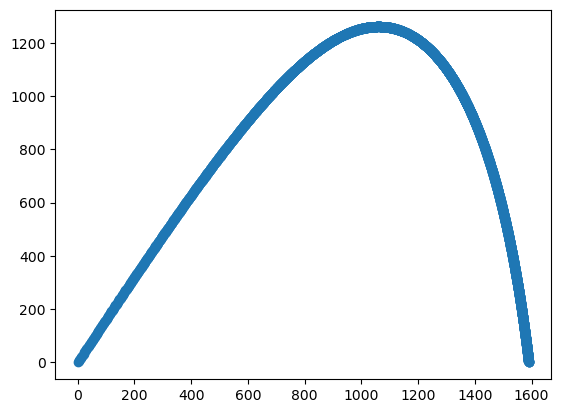

In [1]:
import numpy as np
# from data_generator import perfect_balistic_data_with_air_resistance, noisy_balistic_data_with_air_resistance
# from fitting import train_nn, reset_all_weights
import matplotlib.pyplot as plt
import torch.nn


s_x,s_y, t = perfect_balistic_data_with_air_resistance(500, 45, mass=10.43, rho=1.2, dt=0.1, Cd=0.47, sphere_radius=0.11)

fig = plt.figure()
plt.plot(s_x, s_y, 'o')


### Real data

In real world scenerions we might not have the data that spam through the entire domain and the data might not be super clean as well.
In the plot below I try to emulate the real world scenario by adding some noise to the data and by only sampling the data in a small region of the domain.


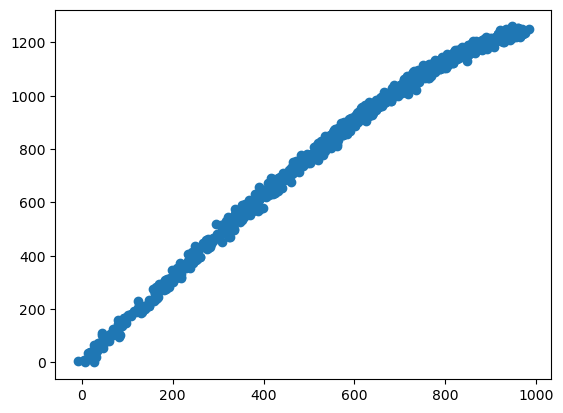

In [2]:
s_x, s_y, t = noisy_balistic_data_with_air_resistance(500, 45, mass=10.43, rho=1.2, dt=0.1, Cd=0.47, sphere_radius=0.11, noise=10)

index = 1000
plt.plot(s_x[0:index], s_y[0:index], 'o')

## First fitting attempt


Fitting a model once you have the entire domain is easy as we can see below.
For this example we will use a simple 2 layer with the time as input and the positions at x and y as outputs.
We will use the MSE loss function and the Adam optimizer.

As we can see the model is able to fit the data pretty well.

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=128, out_features=2, bias=True)
)


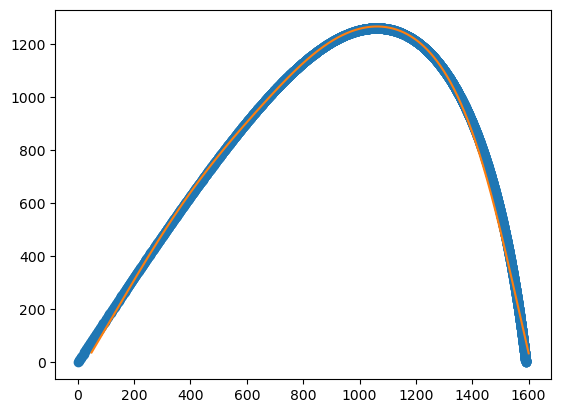

In [3]:
s_x,s_y,t = perfect_balistic_data_with_air_resistance(500, 45, mass=10.43, rho=1.2, dt=0.1, Cd=0.47, sphere_radius=0.11)


# Let's first create a very simple neural network that takes
# the time as input and outputs the x and y coordinates
# of the ball at that time.

# Create a simple neural network
layers = []
layers.append(torch.nn.Linear(1, 128))
layers.append(torch.nn.GELU())
layers.append(torch.nn.Linear(128, 2))
model = torch.nn.Sequential(*layers)
print(model)


# Then we can train the network, t
s_hat = train_nn(s_x, s_y, t, model, epochs=20)



plt.plot(s_x, s_y, 'o')
plt.plot(s_hat[:, 0], s_hat[:, 1])


## However, having only part of the domain....

 it is nearly impossible to have a good fit as we can see here.

 We can try to apply different regularization techniques to try to improve the fit but it is difficult if you don't have any prior knowledge of the problem.


(3196, 2)
3196


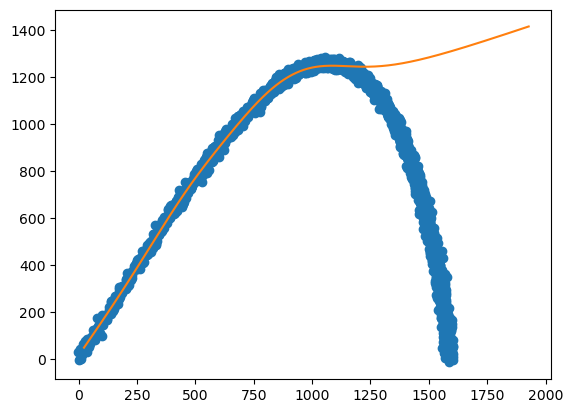

In [4]:
s_x, s_y, t= noisy_balistic_data_with_air_resistance(500, 45, mass=10.43, rho=1.2, dt=0.1, Cd=0.47, sphere_radius=0.11, noise=10)


index = 1500
reset_all_weights(model)
s_hat = train_nn(s_x, s_y, t, model, epochs=10, data_offset=index)

plt.plot(s_x, s_y, 'o')
plt.plot(s_hat[:, 0], s_hat[:, 1])
print(s_hat.shape)
print(len(s_x))

## Physics Informed Neural Network (PINN) in action

The current NN we trained minimizes the MSE loss. 

However we can add a loss term that enforces the physics of the problem.
For instance the acceleration of a projectile is given by

$\overrightarrow{\text{a}} -\mu ||\overrightarrow{\text{v}}||\overrightarrow{\text{v}} - \overrightarrow{\text{g}}$, where $\overrightarrow{\text{v}}$ is the velocity vector, $\overrightarrow{\text{g}}$ is the gravity vector and $\mu$ is the drag coefficient.

The ODEs for velocity and the acceleration are given by:

$\overrightarrow{\text{v}} = \frac{d\overrightarrow{\text{f}}}{dt}$

and

$\overrightarrow{\text{a}} = \frac{d^2\overrightarrow{\text{f}}}{dt^2}$.

Then:

$\frac{d^2\overrightarrow{\text{f}}}{dt^2} = -\mu || \frac{d\overrightarrow{\text{f}}}{dt}  ||\frac{d\overrightarrow{\text{f}}}{dt} - g $.

We can use the equation above as a regulizer for the NN by using the auto-grad to compute these derivatives. The loss function can be crafted as:

$L_{\text{physics}} = \frac{1}{n} \sum\limits_{i=1}^{n}(-\mu || \frac{d\overrightarrow{\text{f}}}{dt}  ||\frac{d\overrightarrow{\text{f}}}{dt} - g) - \frac{d^2\overrightarrow{\text{f}}}{dt^2}$

The samples used to train the physics loss are randomly sampled across the entire domain.
Note that we don't need the targets for the physics loss as we are only interested in the derivatives of the NN outputs.
Follow a snippet from the original blog post:

"The data loss is trained with samples from the training data, and the physics loss is trained with samples from across the entire domain of interest (which we specify). As the physics loss requires only inputs across the domain and no targets, we are free to choose any appropriate sampling strategy (e.g. uniform sampling being a simple strategy)."


As you can see in the plot below, the model was able to better fit one the physics of the problem is introduced.

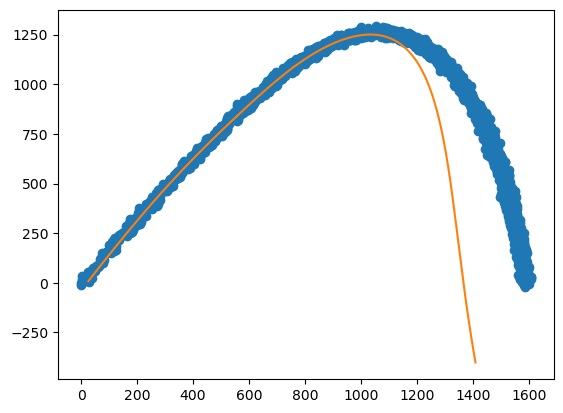

In [5]:
#from fitting import simple_pinn_train_loop

s_x, s_y, t= noisy_balistic_data_with_air_resistance(500, 45, mass=10.43, rho=1.2, dt=0.1, Cd=0.47, sphere_radius=0.11, noise=10)

reset_all_weights(model)
#indexes = np.where(data[:,1]>0)
index = 1500

s_hat = train_nn(s_x, s_y, t, model, epochs=100, data_offset=index, train_fn=simple_pinn_train_loop, phys_weight=1e-2)


plt.plot(s_x, s_y, 'o')
plt.plot(s_hat[:, 0], s_hat[:, 1])
